# This notebook will handle all functional decoding of the subjects' functional connectivity maps and the concept maps. 

In [16]:
import nibabel as nib
import numpy as np
from neuromaps import stats, parcellate
import brainsmash
from brainsmash.workbench.geo import volume
from brainsmash.mapgen.eval import sampled_fit
from statsmodels.stats import multitest
import matplotlib.pyplot as plt
from brainsmash.mapgen.sampled import Sampled
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import os
import seaborn as sns
from src.cdr import compute_cdr

from nilearn import plotting

wd = os.path.dirname(os.getcwd())
data_dir = os.path.join(wd, 'data')
maps_dir = os.path.join(data_dir, 'results', 'concept_maps', 'corrected_fdr')
rsn_dir = os.path.join(data_dir, 'RSN')
output_dir = os.path.join(wd, 'data', 'results', 'RSN')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

high_low_order = ['motor', 'eye_movements', 'motion_perception', 'visual_perception', 'auditory_perception','tactile_perception', 'pain', 
                  'action','facial_perception', 'multisensory_integration', 'attention',  'working_memory', 'inhibition',
                  'memory', 'language', 'numerical_cognition', 'cognitive_control', 'imagery', 'social_cognition', 'emotion', 'decision_making',
                  'reward_processing']


We initialize the parcellator based on an ROI atlas with 2507 ROIS. This makes all further analyses computationally lighter; as more ROIS (or voxels) require a larger distance matrix that is needed to compute brain surrogate maps later on. 

We also compute the distance matrix of this ROI atlas, using the coordinates of the centroid of each ROI. 

In [17]:
from src.generate_cdr_report import data

# Load in the complete atlas that the parcellator is based off of
ROI_atlas = nib.load(data.PARCELLATION)
ROI_atlas_volume = ROI_atlas.get_fdata()
mask = ROI_atlas_volume > 0
n_rois = len(np.unique(ROI_atlas_volume)) -1
volume_shape = ROI_atlas_volume.shape

sample_image = ROI_atlas

if not os.path.exists(os.path.join(data.TEMP_DIR, 'parcellation_coordinates.txt')):
    centroids = []

    # Iterate over each parcel ID to calculate the centroid
    for parcel_id in np.unique(ROI_atlas_volume):
        if parcel_id == 0:
            continue
        # Get the coordinates of the voxels in the current parcel
        coords = np.argwhere(ROI_atlas_volume == parcel_id)  # Get voxel indices
        
        # Calculate the centroid as the mean of the coordinates
        centroid = coords.mean(axis=0)  # mean across x, y, z dimensions
        centroids.append(np.round(centroid).astype(int))

    # Save the centroids to a text file
    np.savetxt(os.path.join(data.TEMP_DIR, 'parcellation_coordinates.txt'), centroids, fmt='%d')
else:
    print('Using existing parcellation coordinates files.')

# Initialize the parcellater
parcellater = parcellate.Parcellater(ROI_atlas, space='MNI152', resampling_target='data')

# Make the distance matrix, coordinates are calculated from the centroids of each ROI, this is used to create null maps later
coord_file = os.path.join(data.TEMP_DIR, 'parcellation_coordinates.txt')

filenames = brainsmash.workbench.geo.volume(coord_file, data.TEMP_DIR)

Using existing parcellation coordinates files.
loading voxels coordinates from /home/antoniojm/Documents/projects/git/CogNet-stroke/src/generate_cdr_report/data/temp/parcellation_coordinates.txt
file contains 2507 voxels
saving memory-mapped distance matrix files to /home/antoniojm/Documents/projects/git/CogNet-stroke/src/generate_cdr_report/data/temp


Load in and parcellate the Neurosynth concept maps.

In [18]:
# Define terms and their corresponding names
term_names = ['facial_perception', 'attention', 'working_memory', 'imagery', 'language', 
              'motion_perception', 'numerical_cognition', 'inhibition', 'motor', 'reward_processing', 
              'visual_perception', 'eye_movements', 'action', 'pain', 'memory',  'emotion', 'cognitive_control',
              'social_cognition', 'decision_making', 'auditory_perception', 'multisensory_integration', 'tactile_perception']

concept_maps = {}

for name in term_names:
    # Load the map for the corresponding term ID
    concept_image_file = f"{name}_z_desc-association_level-voxel_corr-FDR_method-indep.nii.gz"
    concept_image = nib.load(os.path.join(maps_dir, concept_image_file))

    # Extract and preprocess the volume
    concept_volume = concept_image.get_fdata()
    
    # Parcellate the rescaled concepts
    parcellated_concept = parcellater.fit_transform(concept_image, space='MNI152')

    # Convert back to NIfTI images
    parcellated_concept_img = parcellater.inverse_transform(parcellated_concept)

    # Get voxel data for storage
    parcellated_concept_volume = parcellated_concept_img.get_fdata().squeeze()


    # Store the maps in the dictionary under the new name
    concept_maps[name] = {
        'original_image': concept_image,
        'original_volume': concept_volume,
        'parcellated_image': parcellated_concept_img,
        'parcellated_volume': parcellated_concept_volume,
        'parcellated_values': parcellated_concept,
    }


The files `HBM_TahSchw23_rsn10.nii.gz` and `groupICA_HCP1200_multi_d15-300.nii.gz` can be downloaded from https://osf.io/mek47/. And should be stored in `/data/RSN` together with a gray matter mask and the seeds `dorsal_attention`, `salience` and `language` extracted from [CONN toolbox](https://web.conn-toolbox.org/)

In [19]:
from nilearn.image import iter_img
from nilearn.image import index_img
from nilearn.image import concat_imgs

networks_smith = ['medial visual', 'occipital pole', 'lateral visual',
            'DMN', 'cerebellum', 'sensorimotor', 'auditory', 'executive control',
            'frontoparietal right', 'frontoparietal left']
networks_conn = ['dorsal_attention', 'salience', 'language']
networks_high_to_low = ["executive control","frontoparietal left", "frontoparietal right", "DMN",
    "language", "salience", "dorsal_attention", "lateral visual", "auditory", "occipital pole", "medial visual", 
    "sensorimotor", "cerebellum"]

networks_smith_image = nib.load(os.path.join(rsn_dir, 'HBM_TahSchw23_rsn10', 'HBM_TahSchw23_rsn10.nii.gz'))
hcp_groupICA = nib.load(os.path.join(rsn_dir, 'groupICA_HCP1200_multi_d15-300.nii.gz'))
gm_mask = nib.load(os.path.join(rsn_dir, 'gm_mask_2mm.nii.gz'))
networks_conn_best_ica_list = []
for network in networks_conn:
    network_img = nib.load(os.path.join(rsn_dir, f'{network}_mask.nii.gz'))
    network_data = network_img.get_fdata()
    network_outside = gm_mask.get_fdata() - network_img.get_fdata()
    network_data[network_outside == 1] = -1
    best_network_representation = []
    for ica_comp in iter_img(hcp_groupICA):
        ica_comp_data = ica_comp.get_fdata()
        ica_comp_pos = ica_comp_data.flatten() * np.where(ica_comp_data>0,1,0).flatten()
        best_network_representation.append(compute_cdr(network_data.flatten(), ica_comp_pos))
    best_network_representation = np.array(best_network_representation)
    best_network_ica_img = index_img(hcp_groupICA, best_network_representation.argmax())
    networks_conn_best_ica_list.append(best_network_ica_img)
networks_conn_best_ica_img = concat_imgs(networks_conn_best_ica_list)
networks_13_img = concat_imgs([networks_smith_image, networks_conn_best_ica_img])
networks_13_list = networks_smith + networks_conn


In [20]:
network_maps_hcp = {}
for network, img in zip(networks_13_list, iter_img(networks_13_img)):
    # Parcellate the network
    parcellated_network = parcellater.fit_transform(img, space='MNI152')
    parcellated_network_img = parcellater.inverse_transform(parcellated_network)
    parcellated_network_volume = parcellated_network_img.get_fdata().squeeze()

    # Store the network in the list
    network_maps_hcp[network] = {
        'original_image': img,
        'original_volume': img.get_fdata(),
        'parcellated_image': parcellated_network_img,
        'parcellated_volume': parcellated_network_volume,
        'parcellated_values': parcellated_network
    }

Check to see if the arguments that are used to make brain surrogate maps are valid and create good surrogates.
- ns = number of samples
- knn = k-Neirest neigbors
- pv = percentage of pairwise distance at which to truncate variogram fitting
- nh = number of uniformly spaced distance intervals within which to compute variance when constructing variograms

loading voxels coordinates from /home/antoniojm/Documents/projects/git/CogNet-stroke/src/generate_cdr_report/data/temp/parcellation_coordinates.txt
file contains 2507 voxels
saving memory-mapped distance matrix files to /home/antoniojm/Documents/projects/git/CogNet-stroke/data/results/RSN


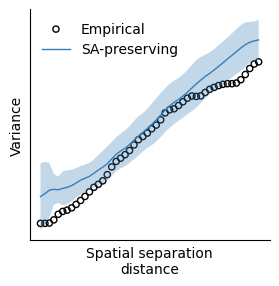

In [21]:
filenames = brainsmash.workbench.geo.volume(coord_file, output_dir)

# These are three of the key parameters affecting the variogram fit

kwargs = {'ns': 250,
          'knn': 200,
          'pv': 70, 
          'nh':50,
          }

sampled_fit(concept_maps['working_memory']['parcellated_values'].squeeze(), filenames['D'], filenames['index'], nsurr=10, **kwargs)

Correlation between the Neurosynth concept maps and the functional connectivity maps (positive and negative) from the RSN maps. Significance is defined by comparing the correlation to a null distribution of surrogate brain maps that hold the same spatial autocorrelation as the relevant concept map.

Correlate the lemon RSN maps to the concept maps.

In [22]:
# Correlation RSN and concepts
corr = []
p = []
all_networks = []
all_concepts = []

n_nulls = 5000

for idx, concept in enumerate(concept_maps.keys()):
    print(f"Processing concept {idx + 1}/{len(concept_maps.keys())}: {concept}")
    
    # Generate nulls for the main concept array
    nulls = Sampled(x=concept_maps[f'{concept}']['parcellated_values'].squeeze(), D=filenames['D'], index=filenames['index'], n_jobs=-1, **kwargs)(n_nulls).T

    for idx, network in enumerate(networks_13_list):
        all_networks.append(network)
        all_concepts.append(concept)
        
        # Calculate correlations for the neuroquery array
        corr_n = stats.compare_images(concept_maps[f'{concept}']['parcellated_values'].squeeze(), network_maps_hcp[network]['parcellated_values'], metric='pearsonr', nulls=nulls, return_nulls=False)

        # Append correlation results for the neuroquery array
        corr.append(corr_n[0])
        p.append(corr_n[1])

df_networks_hcp = pd.DataFrame({'network': all_networks, 'concept': all_concepts, 'corr': corr, 'p': p})

Processing concept 1/22: facial_perception


Processing concept 2/22: attention
Processing concept 3/22: working_memory
Processing concept 4/22: imagery
Processing concept 5/22: language
Processing concept 6/22: motion_perception
Processing concept 7/22: numerical_cognition
Processing concept 8/22: inhibition
Processing concept 9/22: motor
Processing concept 10/22: reward_processing
Processing concept 11/22: visual_perception
Processing concept 12/22: eye_movements
Processing concept 13/22: action
Processing concept 14/22: pain
Processing concept 15/22: memory
Processing concept 16/22: emotion
Processing concept 17/22: cognitive_control
Processing concept 18/22: social_cognition
Processing concept 19/22: decision_making
Processing concept 20/22: auditory_perception
Processing concept 21/22: multisensory_integration
Processing concept 22/22: tactile_perception


Bonferroni correction

In [23]:
# Loop through each unique subject
for net in df_networks_hcp['network'].unique():
    df_net = df_networks_hcp[df_networks_hcp['network'] == net]  # Filter for the current network
    
    # Apply multiple testing correction for 'pos_corr_p' column
    significance, corrected, _, _ = multitest.multipletests(df_net['p'], alpha=0.05, method='bonferroni')
    
    # Add the results back to the dataframe
    df_networks_hcp.loc[df_networks_hcp['network'] == net, 'significance'] = significance
    df_networks_hcp.loc[df_networks_hcp['network'] == net, 'corrected'] = corrected

df_networks_hcp.to_csv(os.path.join(output_dir, 'RSN_concept_correlations_hcp.csv'), index=False)

Plot of the significant correlations between the networks (x-axis) and the concepts (y-axis)

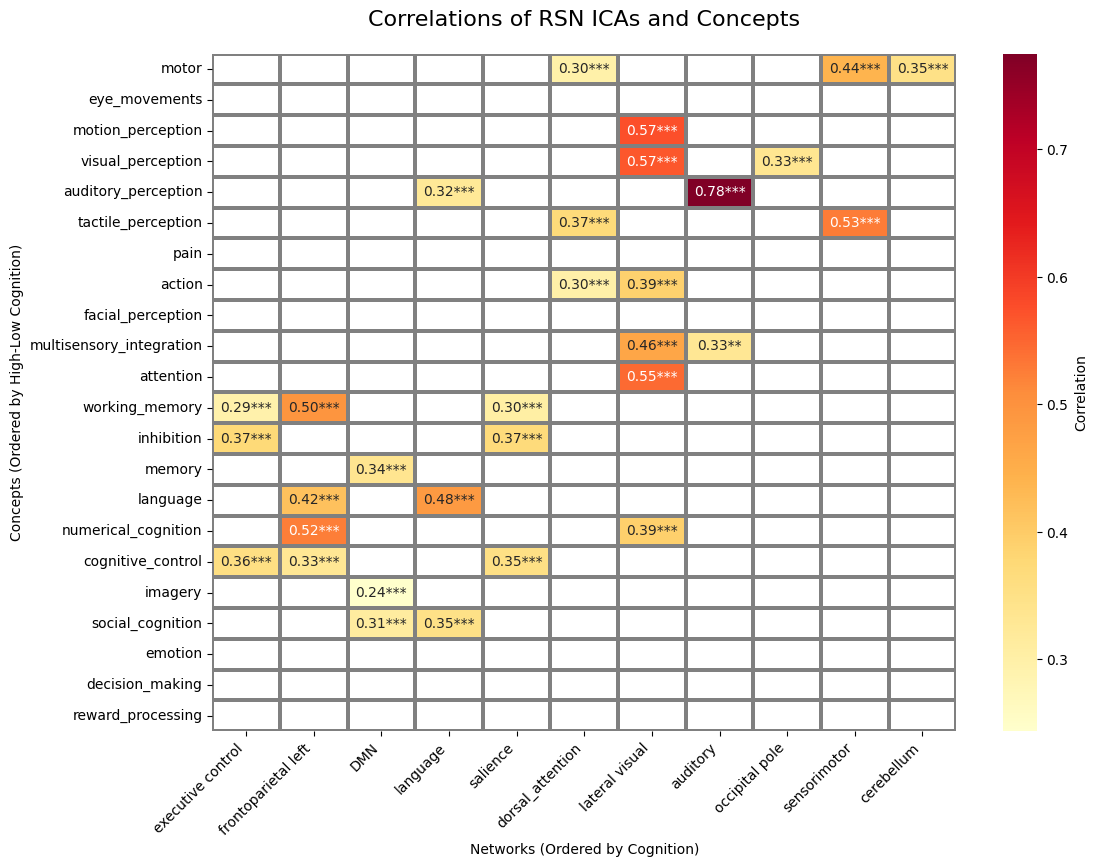

In [24]:
# Load data
df_networks_hcp = pd.read_csv(os.path.join(output_dir, 'RSN_concept_correlations_hcp.csv'))

# Define function for significance stars
def significance_stars(p):
    """Assign significance stars based on p-value."""
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    return ""

# Filter based on significance markers for poscorr (non-nq version)
df_significant = df_networks_hcp[df_networks_hcp["significance"] & (df_networks_hcp["corr"] > 0)].copy()

# Create correlation columns with significance stars
df_significant["correlation_label"] = df_significant.apply(
    lambda row: f"{row['corr']:.2f}{significance_stars(row['p'])}", axis=1
)

# Create pivot table for heatmap labels (correlation values + stars)
heatmap_labels = df_significant.pivot(index="concept", columns="network", values="correlation_label")

# Create pivot table for heatmap values (actual correlations)
heatmap_data_hcp = df_significant.pivot(index="concept", columns="network", values="corr")

# Ensure rows (concepts) follow the predefined high_low_order
heatmap_data_hcp = heatmap_data_hcp.reindex(high_low_order).fillna(0)
heatmap_labels = heatmap_labels.reindex(high_low_order).fillna("")

# remove from networks_high_to_low such networks not included in heatmap_data_hcp.columns
networks_high_to_low = [network for network in networks_high_to_low if network in heatmap_data_hcp.columns]

# order the columns (networks) based on the order of networks
heatmap_data_hcp = heatmap_data_hcp[networks_high_to_low]
heatmap_labels = heatmap_labels[networks_high_to_low]



# Define figure size dynamically based on data shape
fig_width = max(12, heatmap_data_hcp.shape[1] * 0.5)  
fig_height = max(8, heatmap_data_hcp.shape[0] * 0.4)  

# Mask zeros in the heatmap
mask = heatmap_data_hcp == 0

# Plot heatmap with significance stars
plt.figure(figsize=(fig_width, fig_height))
sns.heatmap(
    heatmap_data_hcp, 
    cmap="YlOrRd", 
    annot=heatmap_labels,  # Show labels with stars
    fmt="",  # No numerical formatting needed as it's already included in labels
    cbar_kws={'label': 'Correlation'},
    linewidths=1.5,  # Stronger grid lines for better readability
    linecolor='gray',  # Make grid lines more visible
    mask=mask  # Hide zero values
)

plt.savefig(os.path.join(output_dir, 'RSN_validation.svg'), format='svg', dpi=300)

plt.title("Correlations of RSN ICAs and Concepts", fontsize=16, pad=20)
plt.xlabel("Networks (Ordered by Cognition)")
plt.ylabel("Concepts (Ordered by High-Low Cognition)")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.show()

